### 1. Loading data from url

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

url = 'https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv'

In [57]:
data = pd.read_csv(url)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8573 entries, 0 to 8572
Data columns (total 9 columns):
holiday                8573 non-null object
temp                   8573 non-null float64
rain_1h                8573 non-null float64
snow_1h                8573 non-null int64
clouds_all             8573 non-null int64
weather_main           8573 non-null object
weather_description    8573 non-null object
date_time              8573 non-null object
traffic_volume         8573 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 602.9+ KB


In [58]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [59]:
data.set_index("date_time",inplace=True)

In [60]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2013-01-01 00:00:00,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,1439
2013-01-01 01:00:00,None,263.78,0.0,0,40,Clouds,scattered clouds,1502
2013-01-01 02:00:00,None,264.16,0.0,0,75,Snow,heavy snow,933
2013-01-01 03:00:00,None,263.95,0.0,0,90,Clouds,overcast clouds,576
2013-01-01 04:00:00,None,263.65,0.0,0,90,Clouds,overcast clouds,372
...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,None,248.13,0.0,0,1,Clear,sky is clear,4504
2013-12-31 20:00:00,None,247.66,0.0,0,1,Clear,sky is clear,3478
2013-12-31 21:00:00,None,248.63,0.0,0,1,Clear,sky is clear,2711


### 2. Distribution of variables

First, let's take a quick look at the columns to see what sort of data we are working with.

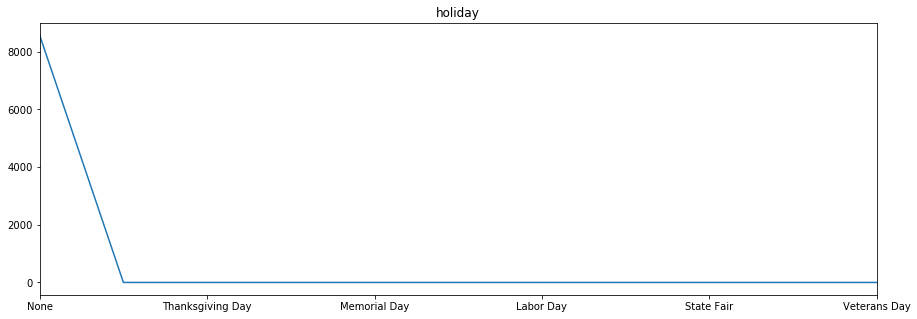

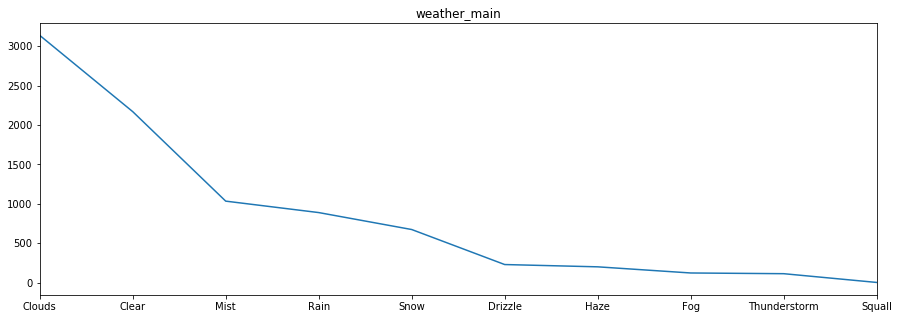

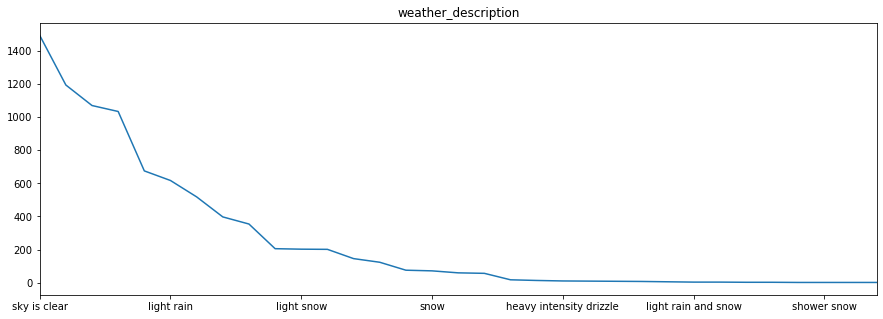

In [72]:
for col in data.columns:
    if data[col].dtypes == 'O':
        plt.figure(col,figsize=(15,5))
        plt.title(col)
        data[col].value_counts().plot()

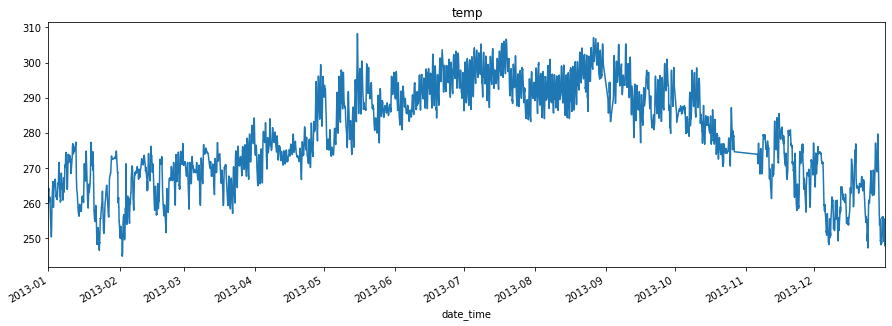

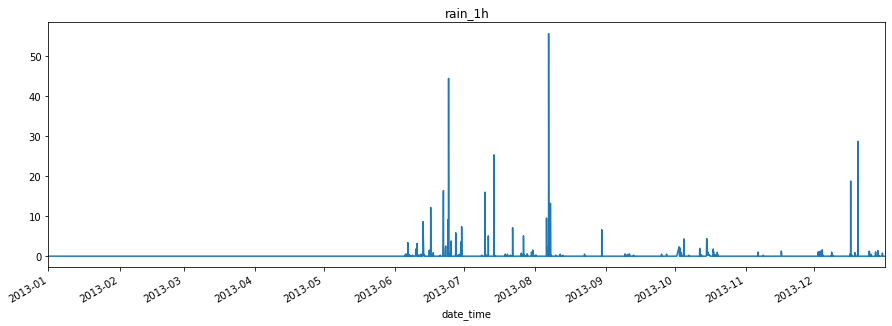

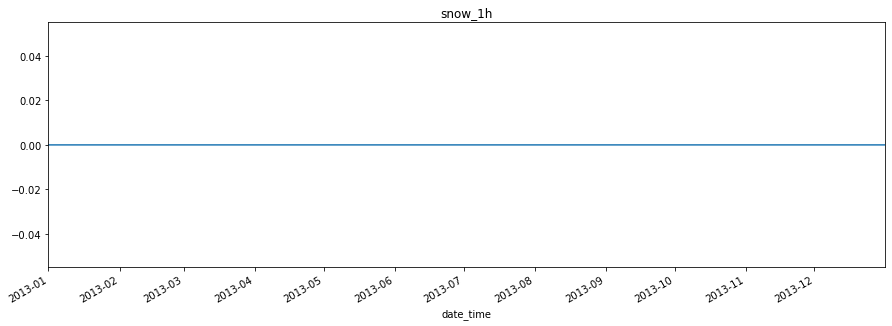

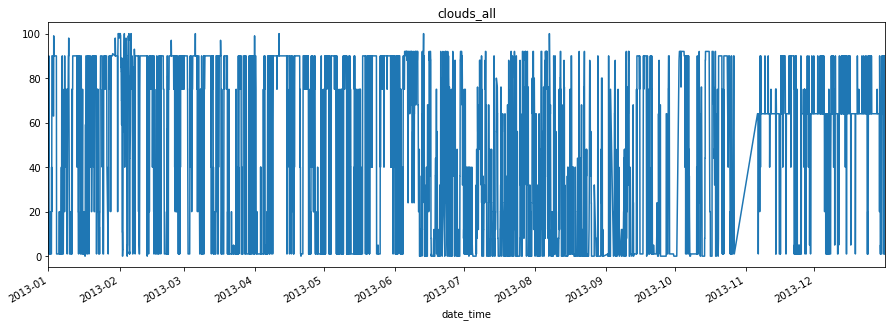

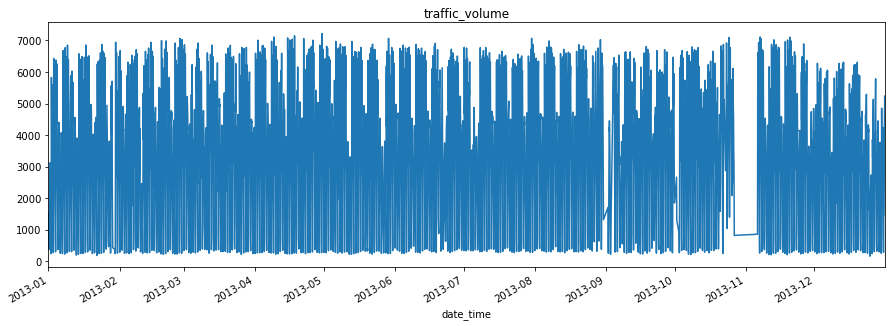

In [73]:
for col in data.columns:
    if data[col].dtypes != 'O':
        plt.figure(col,figsize=(15,5))
        plt.title(col)
        data[col].plot()

#### Holiday
There are only a few instances of holidays scattered throughout the year. Most of the values are none.

#### Weather_main, weather_description
Weather main is the main type of weather, while weather description goes further in depth on the type of weather.
Most of the days are cloudy, clear, misty, rainy or snowy. I will most likely keep only 1 column for the modelling to avoid collinearity.

#### Temp
We note that temperature has a seasonal pattern annually.

#### Rainfall
Rain is sporadic through the year with no discernible pattern except that it only occurs in the later half of the year.

#### Snow
Despite the weather columns having 'snow' as a type, snow is recorded at 0 throughout. I will drop this column.

#### Clouds
No discernible pattern, random and high variance - to look at relationship with target variable later.

#### Traffic volume (target)
Looks like it has a seasonal component - it would be good to take a deeper look in the relationship it has with time.

In [89]:
try:
    data.drop('snow_1h',axis=1,inplace=True)
except:
    pass

### 3. Predictor variables vs target variable

Now, I'll take a look at the different variables vs traffic volume.

For categorical variables, I'll plot a bar graph using seaborn, which would give us an idea on the mean and range of the traffic volume across the categories.

For numeric variables, I'll take a look at the R coefficient with traffic_volume.

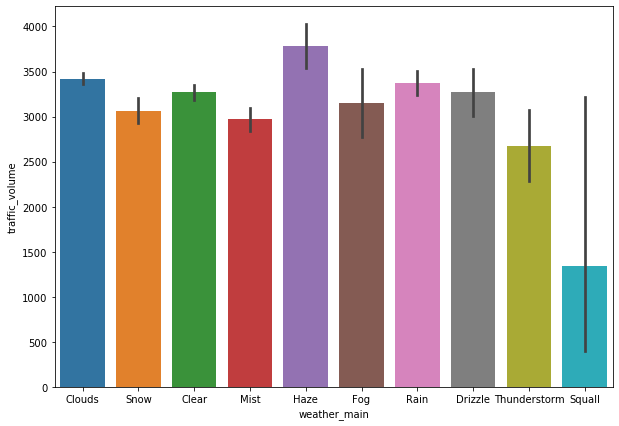

In [13]:
plt.figure(figsize=(10,7))
sns.barplot(x='weather_main',y='traffic_volume',data=data)

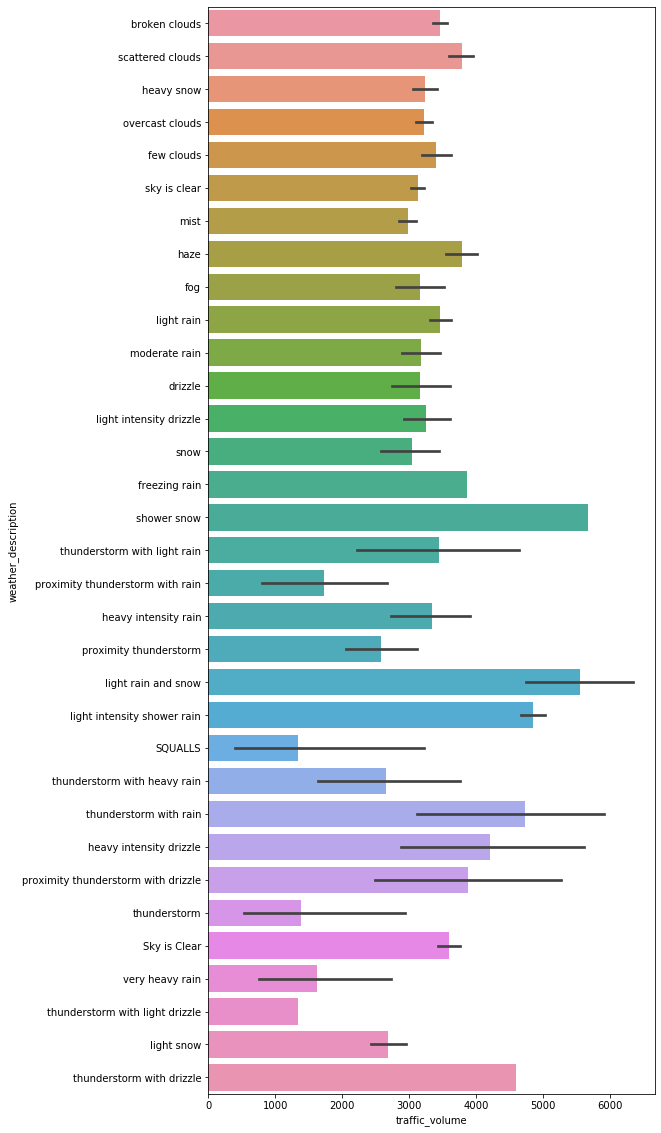

In [74]:
plt.figure(figsize=(8,20))
sns.barplot(x='traffic_volume',y='weather_description',data=data)

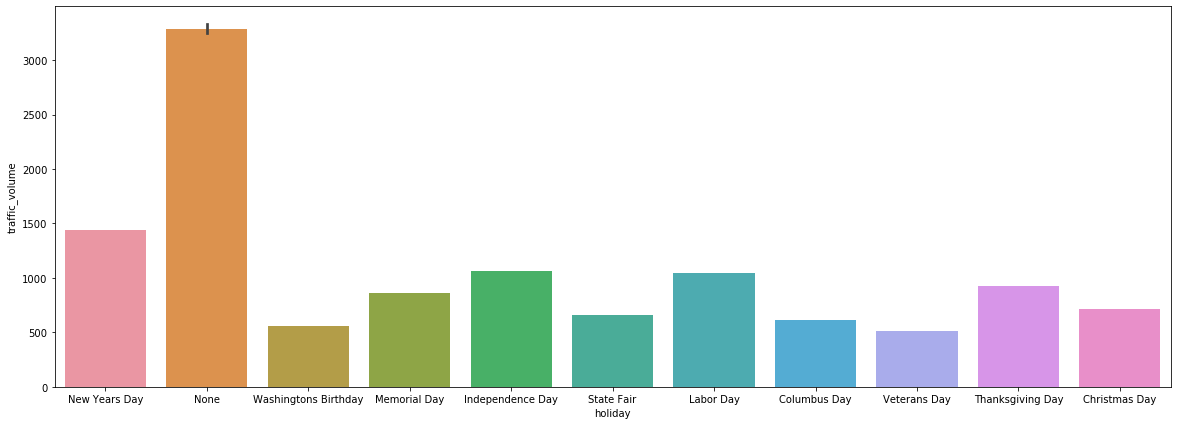

In [21]:
plt.figure(figsize=(20,7))
sns.barplot(x='holiday',y='traffic_volume',data=data)

In [94]:
data.corr()['traffic_volume']

temp              0.152234
rain_1h          -0.032439
clouds_all       -0.002702
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

It looks like there are clear relationships between traffic volume for weather_main, and not so much for weather_description. Most likely I will drop weather_description and keep weather_main and it gives us a better generalisation of traffic volume.

It seems traffic volumes are different across each holiday - however, as there are only 1 instance of each, it is not statistically significant. It may be better to generalise it and use a binary variable to denote if it's a holiday or not.

Temperature, rain and clouds have very low correlation with traffic volume.

Next, features can be extracted from the timestamp.

In [97]:
data['day_of_week']=[i.weekday() for i in data.index]
data['day_of_week']= data['day_of_week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun',})
data['hour']=[i.hour for i in data.index]
data['month']=[i.month for i in data.index]
data['day']=[i.day for i in data.index]

for col in ['hour','month','day']:
    data[col] = data[col].astype(object)

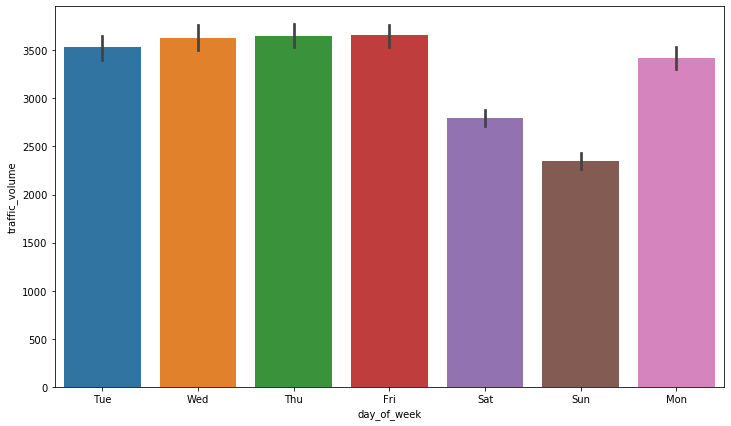

In [96]:
plt.figure(figsize=(12,7))
sns.barplot(x='day_of_week',y='traffic_volume',data=data)

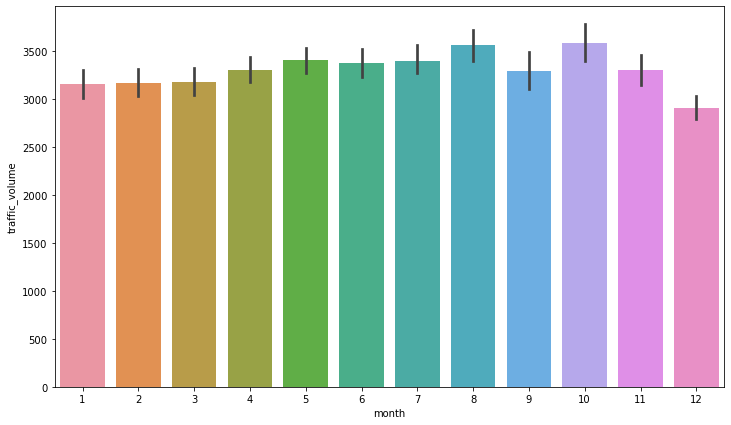

In [98]:
plt.figure(figsize=(12,7))
sns.barplot(x='month',y='traffic_volume',data=data)

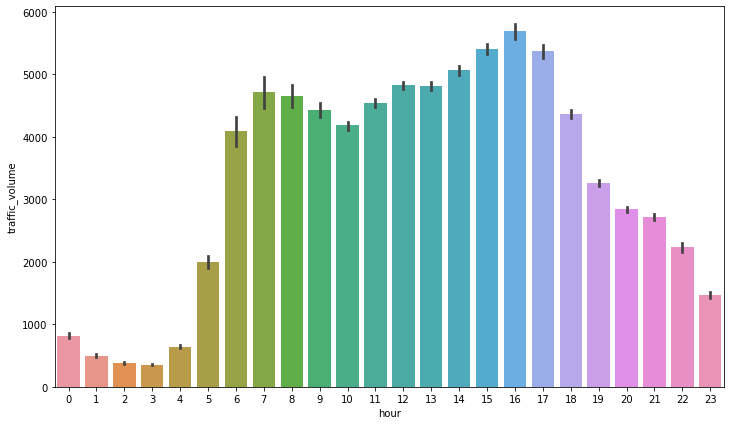

In [99]:
plt.figure(figsize=(12,7))
sns.barplot(x='hour',y='traffic_volume',data=data)

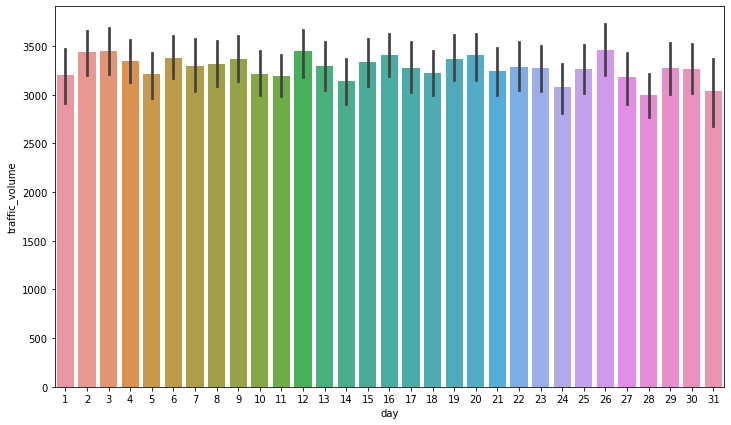

In [100]:
plt.figure(figsize=(12,7))
sns.barplot(x='day',y='traffic_volume',data=data)

From the graphs, there is a noticeable difference in traffic volume across the day of the week, as well as the hour, and not so much for the month, and almost no difference for the day of the month.

### 4. Modelling testing

In this section I will be testing out the performances of different models. Given the dataset, it is possible that you could approach this in a variety of ways - standard time series models using only traffic volume, traditional supervised machine learning models using the various features as inputs as well as neural networks.

It is also prudent to test it with a normalised target variable given the large range of values that can occur.